In [3]:
# This notebook demonstrates fitting a PS by bspline

In [81]:
%pylab inline
import jax_cosmo as jc
import jax.numpy as np
import jax

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [223]:
# Here is a function that produces a power spectrum for provided
# params
k = np.logspace(-2.5,0.5,512)

@jax.jit
@jax.vmap
def get_ps(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    k2 = k / cosmo.h
    return k2*jc.power.linear_matter_power(cosmo,k2)

fid_params = np.array([0.801, 0.2545, 0.0485, 0.682, 0.971, -1])

In [224]:
pk = get_ps(fid_params.reshape((1,-1)))

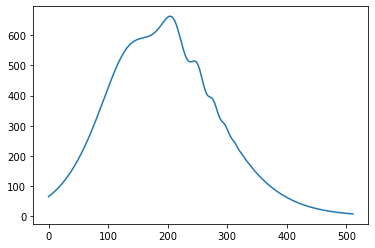

In [225]:
plot(pk[0])

In [226]:
scale_pk = pk.max()

In [227]:
from functools import partial

class Bspline():
    """Numpy implementation of Cox - de Boor algorithm in 1D.
    From here: https://github.com/johntfoster/bspline/blob/master/bspline/bspline.py
    """
    def __init__(self, knot_vector, order):
        """Create a Bspline object.
        Parameters:
            knot_vector: Python list or rank-1 Numpy array containing knot vector
                         entries
            order: Order of interpolation, e.g. 0 -> piecewise constant between
                   knots, 1 -> piecewise linear between knots, etc.
        Returns:
            Bspline object, callable to evaluate basis functions at given
            values of `x` inside the knot span.
        """
        kv = np.atleast_1d(knot_vector)
        if kv.ndim > 1:
            raise ValueError("knot_vector must be Python list or rank-1 array, but got rank = %d" % (kv.ndim))
        self.knot_vector = kv

        order = int(order)
        if order < 0:
            raise ValueError("order must be integer >= 0, but got %d" % (order))

        self.p = order

    def __basis0(self, xi):
        """Order zero basis (for internal use)."""
        return np.where(np.all([self.knot_vector[:-1] <=  xi,
                                xi < self.knot_vector[1:]],axis=0), 1.0, 0.0)

    def __basis(self, xi, p, compute_derivatives=False):
        """Recursive Cox - de Boor function (for internal use).
        Compute basis functions and optionally their first derivatives.
        """

        if p == 0:
            return self.__basis0(xi)
        else:
            basis_p_minus_1 = self.__basis(xi, p - 1)

        first_term_numerator = xi - self.knot_vector[:-p]
        first_term_denominator = self.knot_vector[p:] - self.knot_vector[:-p]

        second_term_numerator = self.knot_vector[(p + 1):] - xi
        second_term_denominator = (self.knot_vector[(p + 1):] -
                                   self.knot_vector[1:-p])


        #Change numerator in last recursion if derivatives are desired
        if compute_derivatives and p == self.p:

            first_term_numerator = p
            second_term_numerator = -p

        #Disable divide by zero error because we check for it
        
        first_term = np.where(first_term_denominator != 0.0,
                              (first_term_numerator /
                               first_term_denominator), 0.0)
        second_term = np.where(second_term_denominator != 0.0,
                               (second_term_numerator /
                                second_term_denominator), 0.0)

        return  (first_term[:-1] * basis_p_minus_1[:-1] +
                 second_term * basis_p_minus_1[1:])
    
    def __call__(self, xi):
        """Convenience function to make the object callable.  Also 'memoized' for speed."""
        @jax.vmap
        def fn(x):
            return self.__basis(x, self.p, compute_derivatives=False)
        return fn(xi)
    
    
    def d(self, xi):
        """Convenience function to compute first derivative of basis functions. 'Memoized' for speed."""
        
        @jax.vmap
        def fn(x):
            return self.__basis(x, self.p, compute_derivatives=True)
        
        return fn(xi)

In [228]:
import flax
from flax import nn, optim

class emulator(nn.Module):
    def apply(self, p, x):
        
        net = nn.leaky_relu(nn.Dense(p, 128))
        net = nn.leaky_relu(nn.Dense(net, 128))
        
        w = nn.Dense(net, 60)
        k = nn.Dense(net, 64)
        
        # make sure  the knots sum to 1 and are in the interval 0,1
        k = np.cumsum(nn.activation.softmax(k,axis=1), axis=1)
        
        @jax.vmap
        def eval_spline(a):
            return Bspline(a, order=3)(x)

        toto = eval_spline(k)
        return np.einsum('bij,bj->bi', eval_spline(k), w)

In [229]:
_, initial_params = emulator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 6,), np.float32), ((512,), np.float32)])
model = flax.nn.Model(emulator, initial_params)

In [230]:
model(fid_params.reshape((1,-1)), x).shape

(1, 512)

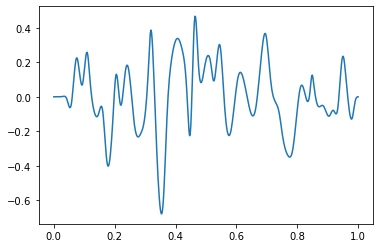

In [231]:
plot(x, model(fid_params.reshape((1,-1)), x)[0])

In [232]:
# function that generates batches of params and pk from prior
import numpy as onp
batch_size=128

def get_batch():
    om = onp.random.uniform(0.1,0.9, batch_size)
    s8 = onp.random.uniform(0.4,1.0, batch_size)
    ob = onp.random.uniform(0.03,0.07, batch_size)
    h = onp.random.uniform(0.55,0.9, batch_size)
    ns = onp.random.uniform(0.87,1.97, batch_size)
    w0 = onp.random.uniform(-2.0,-0.33, batch_size)
    
    p = np.stack([om,s8,ob,h,ns,w0],axis=1)
    pk = get_ps(p)/scale_pk
    return {'x':p, 'y':pk}

In [233]:
batch = get_batch()

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype <class 'jax.num

In [234]:
batch['x'].shape, batch['y'].shape

((128, 6), (128, 512))

In [235]:
model(batch['x'], x).shape

(128, 512)

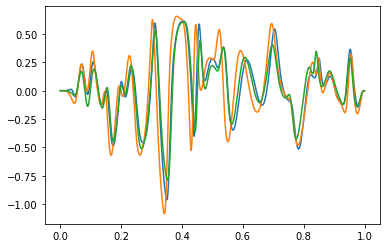

In [236]:
plot(x, model(batch['x'], x)[0])
plot(x, model(batch['x'], x)[1])
plot(x, model(batch['x'], x)[3])

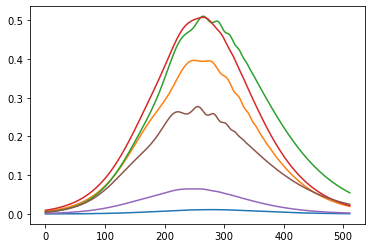

In [241]:
plot(batch['y'][8])
plot(batch['y'][0])
plot(batch['y'][1])
plot(batch['y'][2])
plot(batch['y'][3])
plot(batch['y'][4])



In [242]:
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    pred_y = model(batch['x'], x)
    loss = np.sum((pred_y - batch['y'])**2, axis=1).mean() 
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer,l 

In [243]:
# We also need an optimizer
optimizer = flax.optim.Momentum(learning_rate=0.001, beta=0.9).create(model)

In [244]:
losses = []

In [ ]:
for i in range(1000):
    batch = get_batch()
    optimizer, l = train_step(optimizer, batch)
    losses.append(l)
    if i%100 ==0:
        print(l)

0.20161238


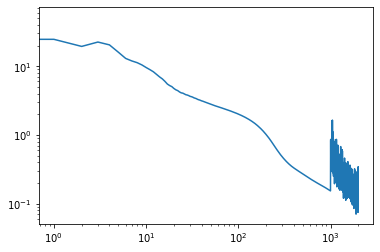

In [251]:
loglog(losses)

(0.0, 1.0)

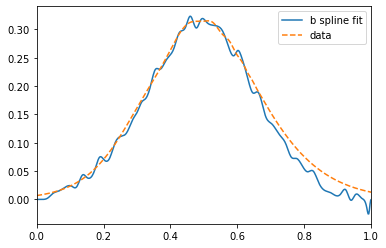

In [252]:
plot(x, optimizer.target(batch['x'], x)[0], label='b spline fit')
plot(x,batch['y'][0],'--', label='data')
legend()
xlim(0,1)

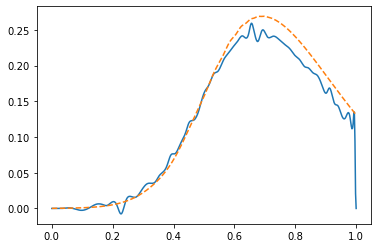

In [254]:
plot(x, optimizer.target(batch['x'], x)[1], label='b spline fit')
plot(x,batch['y'][1],'--', label='data')

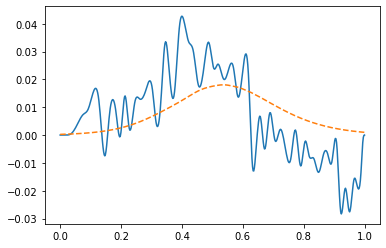

In [255]:
plot(x, optimizer.target(batch['x'], x)[2], label='b spline fit')
plot(x,batch['y'][2],'--', label='data')

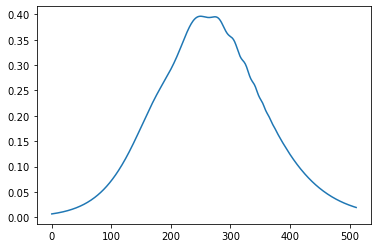

In [248]:
plot(batch['y'][0])

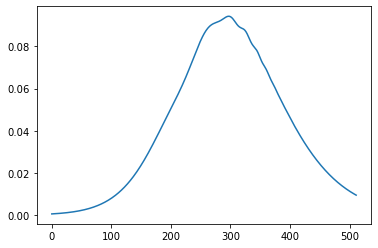

In [216]:
plot(batch['y'][8])

(0.0, 1.0)

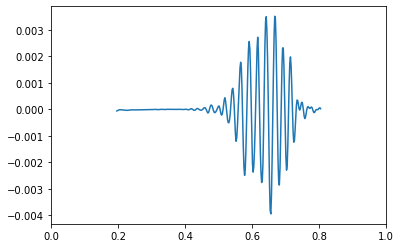

In [124]:
plot(x[100:-100], ((y-optimizer.target(x))/y)[100:-100])
xlim(0,1)

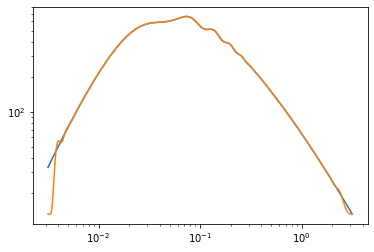

In [126]:
loglog(k,pk)
loglog(k,(optimizer.target(x)*y0.max() + y0.min()))
#xlim(0,0.6)